In [1]:
import matplotlib.pyplot as plt
import gensim
import string
import pandas as pd
import numpy as np
from dsutils import make_semantic_model
from stimulus_utils import load_grids_for_stories, load_generic_trfiles
from dsutils import make_word_ds
from pydub import AudioSegment
import nibabel as nib
from copy import copy
from util import make_delayed

%pylab inline

/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def process_word(word):
    umlautDictionary = {u'Ä': 'Ae', u'Ö': 'Oe', u'Ü': 'Ue',  u'ä': 'ae', u'ö': 'oe', u'ü': 'ue', u'ß':u'ss', 
                       u':': u'', u',':'', u'.':'', u'\'': '', u')':'', u'(':'', '?':'', '"':'',
                        u'[':'', u']':'', '!':'', u'…': ''}
    word = word.decode('utf-8')

    for item, val in umlautDictionary.iteritems():
        word = word.replace(item, val)
    
    return word

In [3]:
model = gensim.models.Word2Vec.load_word2vec_format("/home/medanya/forrest_gump/models/download", binary=True)

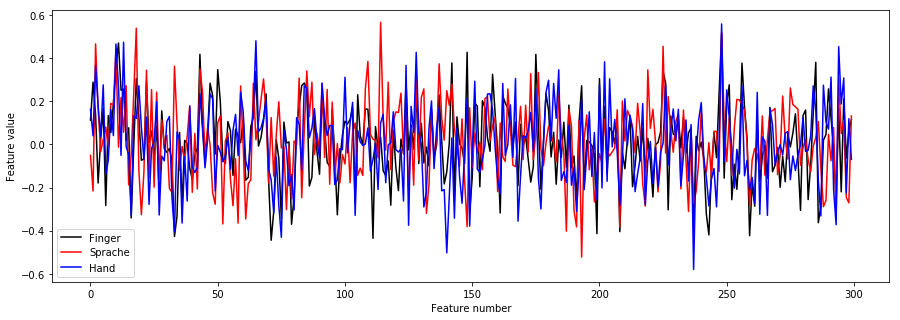

In [4]:
plot_words = ["Finger", "Sprache", "Hand"]
colors = ["k", "r", "b"]

f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
wordlines = []

for word, color in zip(plot_words, colors):
    wordlines.append(ax.plot(model[word], color)[0])

ax.axis("tight")
ax.set_xlabel("Feature number")
ax.set_ylabel("Feature value")
ax.legend(wordlines, plot_words)

In [8]:
def get_vector(word, model=model):
    try:
        return  model[word]
    except Exception as e:
        try:
            return model[word.title()]
        except Exception as e:
            print word
            return np.zeros(300)

In [10]:
def get_stimulus_matrix(segment_id, gr=False):
    folder_path_read = "/home/medanya/forrest_gump/srt"
    
    if gr:
        file_in = folder_path_read + "/segment{}_words.txt".format(segment_id)
    else:
        file_in = folder_path_read + "/segment{}_words_srt.txt".format(segment_id)
        
    words_times = list()
    words_vectors = list()
    words = list()
    
    with open(file_in) as f_in:
        for line in f_in.readlines():
            start, end, word = line.rstrip().split('\t')
            words_times.append((float(start) + float(end)) / 2.)
            words_vectors.append(get_vector(word))
            words.append(word)
            
    return words, np.array(words_times), np.array(words_vectors)

In [12]:
def lanczosfun(cutoff, t, window=3):
    """Compute the lanczos function with some cutoff frequency [B] at some time [t].
    [t] can be a scalar or any shaped numpy array.
    If given a [window], only the lowest-order [window] lobes of the sinc function
    will be non-zero.
    """
    t = t * cutoff
    val = window * np.sin(np.pi*t) * np.sin(np.pi*t/window) / (np.pi**2 * t**2)
    val[t==0] = 1.0
    val[np.abs(t)>window] = 0.0
    return val# / (val.sum() + 1e-10)

In [13]:
def lanczosinterp2D(data, oldtime, newtime, window=3, cutoff_mult=1.0, rectify=False):
    """Interpolates the columns of [data], assuming that the i'th row of data corresponds to
    oldtime(i). A new matrix with the same number of columns and a number of rows given
    by the length of [newtime] is returned.
    
    The time points in [newtime] are assumed to be evenly spaced, and their frequency will
    be used to calculate the low-pass cutoff of the interpolation filter.
    
    [window] lobes of the sinc function will be used. [window] should be an integer.
    """
    ## Find the cutoff frequency ##
    cutoff = 1/np.mean(np.diff(newtime)) * cutoff_mult
    print "Doing lanczos interpolation with cutoff=%0.3f and %d lobes." % (cutoff, window)
    
    ## Build up sinc matrix ##
    sincmat = np.zeros((len(newtime), len(oldtime)))
    for ndi in range(len(newtime)):
        sincmat[ndi,:] = lanczosfun(cutoff, newtime[ndi]-oldtime, window)
    
    if rectify:
        newdata = np.hstack([np.dot(sincmat, np.clip(data, -np.inf, 0)), 
                            np.dot(sincmat, np.clip(data, 0, np.inf))])
    else:
        ## Construct new signal by multiplying the sinc matrix by the data ##
        newdata = np.dot(sincmat, data)

    return newdata

In [32]:
parrent_path = '/home/medanya/forrest_gump/fmri/sub001/BOLD/task001_run00{}/bold.nii.gz'
ind_range = range(300)
delays = range(0, 4)
mri_segments_lengths = [451, 441, 438, 488, 462, 439, 542, 338]

mri = nib.load(parrent_path.format(1)).get_data()
words, wtimes, wvectors = get_stimulus_matrix(0)

new_times = range(0, mri_segments_lengths[0] * 2, 2)

newdata = lanczosinterp2D(wvectors, wtimes, new_times)

newdata_scored = zscore(newdata)      

delayed_wvectors = make_delayed(newdata_scored, delays)
stimulus = copy(delayed_wvectors)

for seg_numb in range(1, 9):
    current_segment = nib.load(parrent_path.format(seg_numb + 1)).get_data()
    mri = np.concatenate([mri, current_segment], axis=3)
    
    w_segment, wt_segment, wv_segment = get_stimulus_matrix(seg_numb)
    
    words.extend(w_segment)
    wtimes = np.concatenate([wtimes, wt_segment], axis=0)
    
    new_times = range(0, mri_segments_lengths[seg_numb] * 2, 2)
    newdata = lanczosinterp2D(wv_segment, wt_segment, new_times)
    newdata_scored = zscore(newdata)      
    delayed_wvectors = make_delayed(newdata_scored, delays)
    
    assert len(delayed_wvectors) == current_segment.shape[-1]
    stimulus = np.concatenate([stimulus, delayed_wvectors], axis=0)

bewoelktem
robertzemeckisfilm
sinise
mykelti
missis
zemeckis
hoerfilmfassung
–
hoerfilm
hochgewirbelt
wartebank
nikelaufschuhe
ausrasiert
kofferdeckel
curious
schwesterntracht
pfundweise
gewesen
peoplemagazine
zauberschuhe
kukluxklan
leintuecher
leintuecher
gullygitter
greenbow
greenbow
greenbowcountycentralschule
iq
curious
hutschachteln
missis
steigst
wartebank
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


wartebank
wartebank
aufzuschauen
davonrasenden
zu…
…
greenbow
tabakfeld
brusthohen
creekmore
beeilung
wiese…
…der
wartebank
footballfeld
–
dorftrottel
footballstadion
mistkerl
tribuenenblock
mistkerl
touchdownlinie
touchdownzone
…
umrennen
…
stadiontor
mistkerl
hin…
…
mitbewohnerin…
…und
bh
ebenmaessiges
bh
…
…
forrests
linst
bh
touchdownzone
collegefootballnationalteam
drpeppercolas
schwarzweissaufnahmen
spielerschlange
praesidententoilette
armywerbebroschuere
armybus
aufwischen
shrimpkutter
shrimpkuttern
batre
bubbas
shrimpgeschaeft
drillsergeant
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
shrimpgeschaeft
drillsergeant
iq
drillsergeant
drillsergeant
spritgeld
drillsergeant
drillsergeant
kompanierekord
offizierskandidaten
sautieren
shrimpkebabs
shrimpkreole
ananasshrimps
zitronenshrimps
kokosnussshrimps
pfeffershrimps
shrimpsuppe
shrimpeintopf
shrimpsalat
shrimpburger
shrimpsandwich
etagenbett
aufgeknoepfter
collegejacke
collegejacke
beatnikschoenheit
dylon
…
…
pling
be

FileNotFoundError: No such file: '/home/medanya/forrest_gump/fmri/sub001/BOLD/task001_run009/bold.nii.gz'

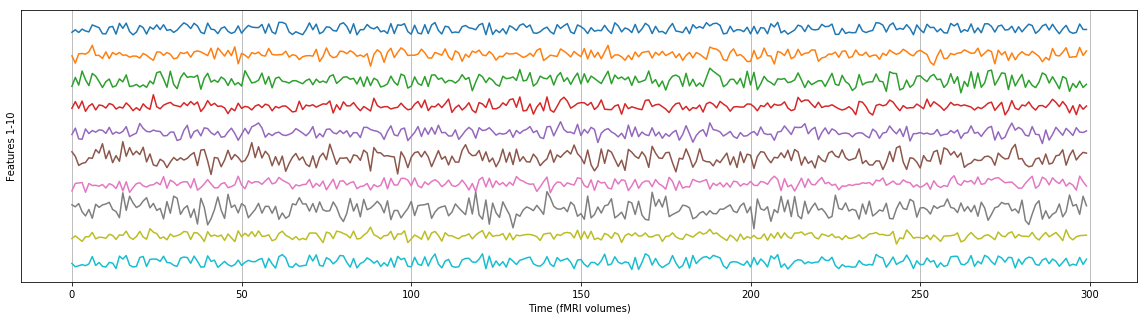

In [34]:
# Plot some of the combined stimuli
from random import choice
from npp import zscore

newdata_scored = zscore(newdata)      
ind_range = range(300)

f = figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(1, 300, 30):
    ax.plot(newdata_scored[ii] - ii/6)

#ax.set_xlim(0, 952)
ax.set_yticks([])
#ax.set_xticks(range(0, 952, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

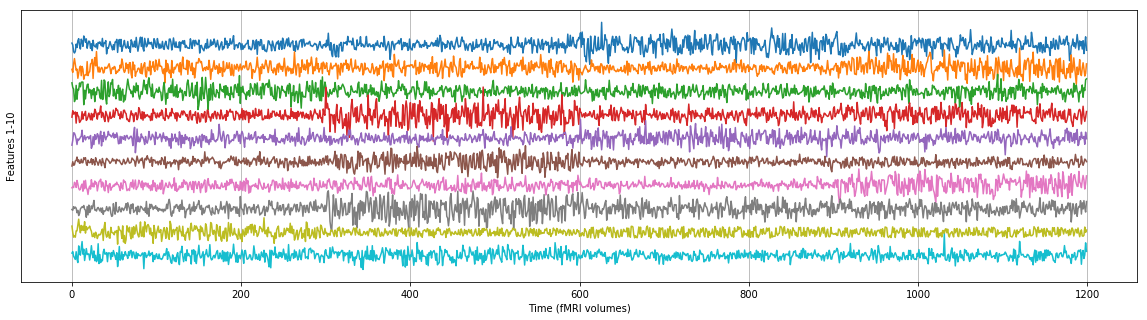

In [36]:
newdata_scored = zscore(newdata)      
ind_range = range(300)

f = figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(6, 300, 30):
    ax.plot(delayed_wvectors[ii] - ii/6)

#ax.set_xlim(0, 952)
ax.set_yticks([])
#ax.set_xticks(range(0, 952, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

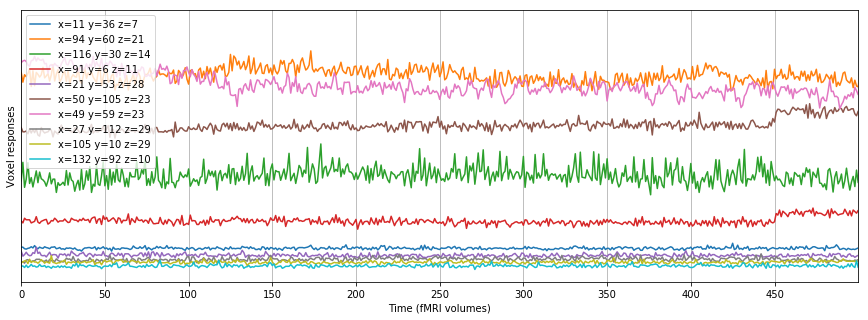

In [37]:
selvoxels = [[choice(range(160)), choice(range(160)), choice(range(36))] for _ in range(10)]

f = figure(figsize=(15, 5))
ax = f.add_subplot(1,1,1)
for ii,vi in enumerate(selvoxels):
    ax.plot(mri[vi[0], vi[1], vi[2]] - 5 * ii, label="x={} y={} z={}".format(vi[0], vi[1], vi[2]))
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Voxel responses")
ax.legend()
ax.grid()